In [1]:
library(nnet)
library(party)
library(caret)
library(party)
library(randomForest)
library(e1071)
library(dplyr)
options(warn=-1)
bodyPerformance <- read.csv('../../Data/프로젝트/bodyPerformance.csv')
bodyPerformance$성별<-ifelse(bodyPerformance$성별=='M',0,1)

Loading required package: grid
Loading required package: mvtnorm
Loading required package: modeltools
Loading required package: stats4
Loading required package: strucchange
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: sandwich
Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin


Attaching package: ‘dplyr’

The following object is masked from ‘package:randomForest’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, 

In [2]:
bodyPerformance$bmi <- round(bodyPerformance$몸무게_kg / (bodyPerformance$키_cm * bodyPerformance$키_cm / 10000),1)
head(bodyPerformance)

나이,성별,키_cm,몸무게_kg,체지방율,이완기혈압_min,수축기혈압_분,악력,앉아서앞으로구부리기_cm,윗몸일으키기,멀리뛰기,등급,bmi
27,0,172.3,75.24,21.3,80,130,54.9,18.4,60,217,C,25.3
25,0,165.0,55.80,15.7,77,126,36.4,16.3,53,229,A,20.5
31,0,179.6,78.00,20.1,92,152,44.8,12.0,49,181,C,24.2
32,0,174.5,71.10,18.4,76,147,41.4,15.2,53,219,B,23.3
28,0,173.8,67.70,17.1,70,127,43.5,27.1,45,217,B,22.4
36,1,165.4,55.40,22.0,64,119,23.8,21.0,27,153,B,20.3


In [3]:
summary(bodyPerformance$bmi)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  11.10   21.60   23.50   23.61   25.30   42.90 

# 이상치 제거 전

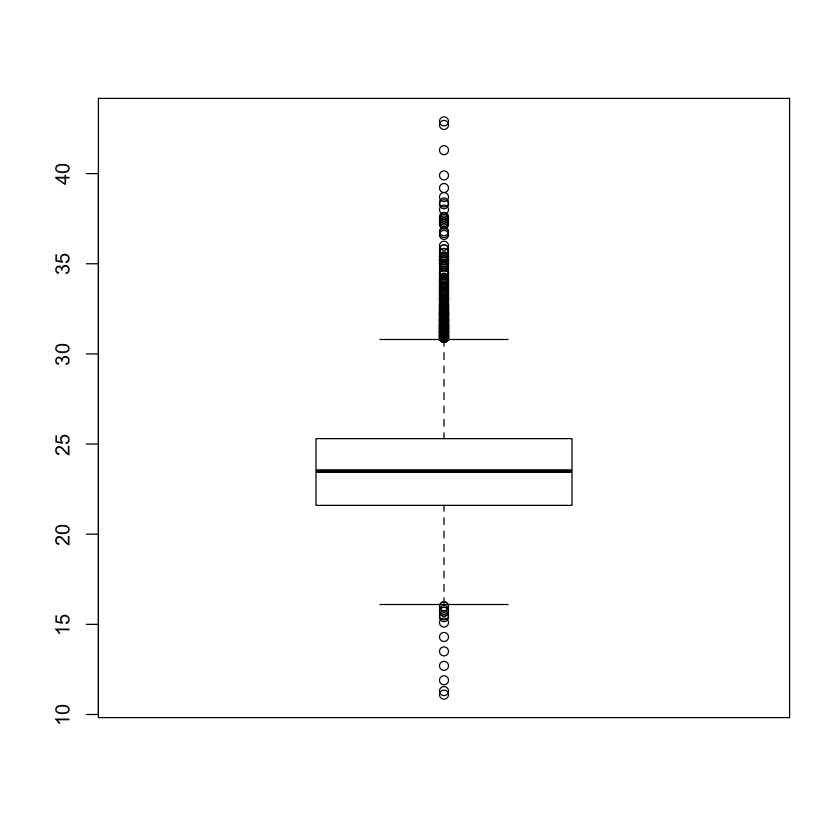

In [4]:
bodyPerformance$bmi <- as.numeric(bodyPerformance$bmi)
bodyPerformance <- arrange(bodyPerformance,등급)
boxplot(bodyPerformance$bmi)

In [5]:
25.30+(25.30-21.60)*3
21.60-(25.30-21.60)*3

[1] 36.4

[1] 10.5

In [6]:
bodyPerformance$bmi <- ifelse(bodyPerformance$bmi > 36.4 , 25.3, bodyPerformance$bmi)
bodyPerformance$bmi <- ifelse(bodyPerformance$bmi < 10.5 , 21.6, bodyPerformance$bmi)

# 이상치 제거 후

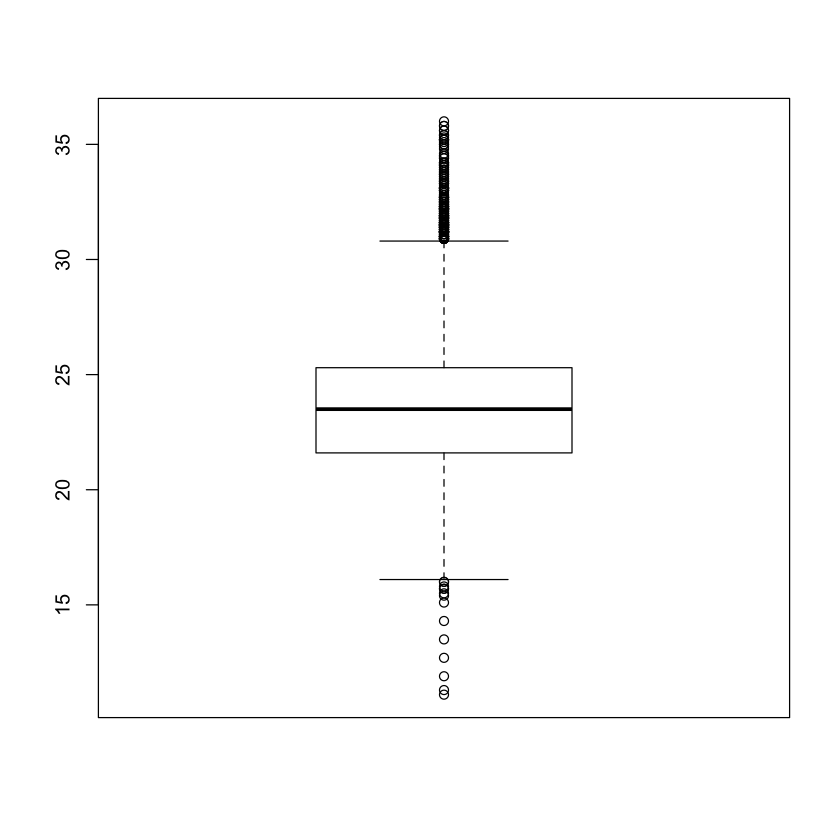

In [7]:
boxplot(bodyPerformance$bmi)

In [8]:
bp_m <- subset(bodyPerformance, 성별 == '0')
bp_f <- subset(bodyPerformance, 성별 == '1')

In [9]:
write.csv(bp_m,'../../Data/bp_m.csv', row.names = F)
write.csv(bp_f,'../../Data/bp_f.csv', row.names = F)
write.csv(bodyPerformance,'../../Data/bp.csv', row.names = F)

In [10]:
write

function (x, file = "data", ncolumns = if (is.character(x)) 1 else 5, 
    append = FALSE, sep = " ") 
cat(x, file = file, sep = c(rep.int(sep, ncolumns - 1), "\n"), 
    append = append)
<bytecode: 0x7fdb0d149ee8>
<environment: namespace:base>

In [15]:
# bmi grouping
bodyPerformance$bmi <- ifelse(bodyPerformance$bmi <18.5,'1',
                  ifelse(bodyPerformance$bmi >= 18.5 & bodyPerformance$bmi <=22.9 ,'2',
                  ifelse(bodyPerformance$bmi >=23 & bodyPerformance$bmi <=24.9,'3',
                  ifelse(bodyPerformance$bmi >=25 & bodyPerformance$bmi <=29.9,'4','5'
                  ))))
등급별bmi <- table(bodyPerformance$bmi, bodyPerformance$등급)

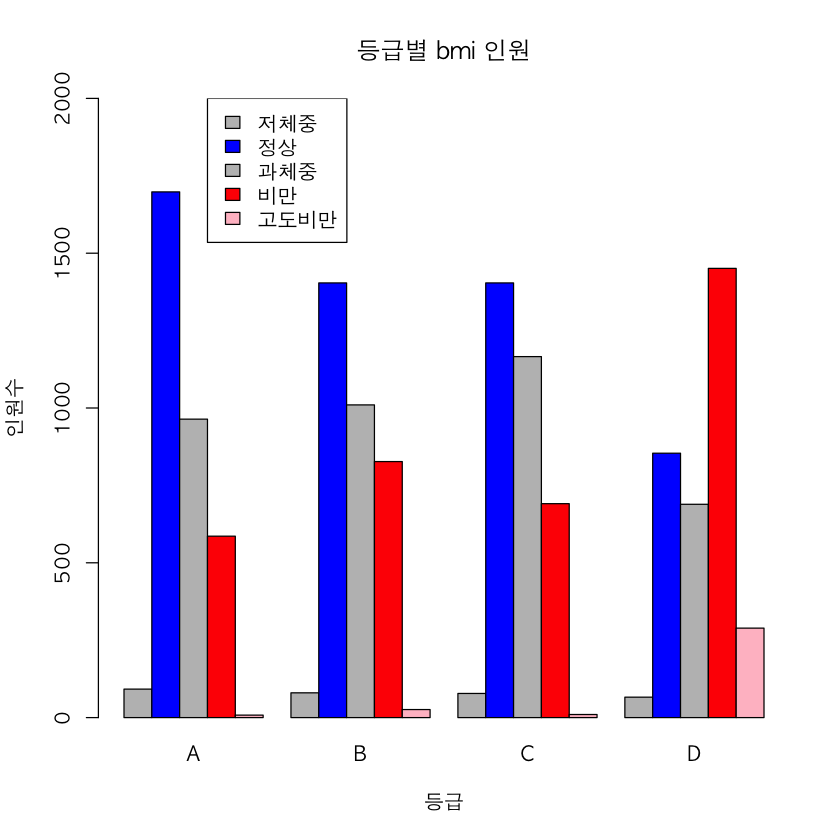

In [14]:
# bmi barplot
par(family ="AppleGothic")
options(warn= -1)
barplot(등급별bmi,
       ylim= c(0,2000),
       main = "등급별 bmi 인원",
       xlab = "등급",
       ylab = "인원수",
       col = c('gray','blue','gray','red','pink'),
        beside = T
       )

legend(4,2000,
      c("저체중","정상","과체중","비만","고도비만"),
     fill = c('gray','blue','gray','red','pink')
      )

In [ ]:
samp <- createDataPartition(bodyPerformance$등급, p=0.7, list=F)
data.tr <- bodyPerformance[samp,]
data.test <- bodyPerformance[-samp,]
x <- subset(data.test, select = -등급)
y <- data.test$등급

# 인공신경망
nnetF <- function(q){
  result = 0
  for(i in 1:q){
    # 학습하기
    nnet <- nnet(등급~.,data=data.tr, size=2)

    # 검증하기
    pred.nnet <- predict(nnet, x,type='class')
    # type class로 0과 1 예측하기

    # 예측율  
    mean(pred.nnet == y)
    table(pred.nnet,y)
    # 예측율  
    result = (result + mean(pred.nnet == y))
  }
  return(result/q)
}
# 의사결정나무
ctreeF <- function(q){
  result = 0
  for(i in 1:q){
  # 학습하기
  ctree <- ctree(등급~.,data=data.tr)

  # 검증하기
  pred.ctree <- predict(ctree, x) # 이하, type class 안해도 0과 1로 예측

  # 예측율
  result <- (result + mean(pred.ctree == y))
  }
  return(result/q)
}
# Random Forest
rfF <- function(q){  
  result = 0
  for(i in 1:q){
  # 학습하기
  rf <- randomForest(등급~.,data=data.tr, ntree=100)

  # 검증하기
  pred.rf <- predict(rf, x)

  # 예측율  
  result <- (result + mean(pred.rf == y))
  }
  return(result/q)
}
# SVM
svmF <- function(q){  
  result = 0
  for(i in 1:q){
  # 학습하기
  svm = svm(등급~.,data=data.tr)

  # 검증하기
  pred.svm <- predict(svm, x)

  # 예측율
  result <- (result + mean(pred.svm == y))
  }
  return(result/q)
}

# 다항 로지스틱 회귀분석
mulF <- function(q){  
  result = 0
  for(i in 1:q){
  # 학습하기
  mul <- multinom(등급~.,data=data.tr)

  # 검증하기
  pred.mul <- predict(mul, x)

  # 예측율  
  result <- (result + mean(pred.mul == y))
  }
  return(result/q)
}
final <- function(q){
  result <- data.frame(예측력=c(nnetF(q),ctreeF(q),rfF(q),svmF(q),mulF(q)))
  rownames(result) <- c('인공신경망','의사결정나무','RandomForest',
                        'SVM','로지스틱회귀분석')
  return(result)
}
final(5)